<a href="https://colab.research.google.com/github/Kirk-KD/CSCA20-Project/blob/master/CS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculator Project

## Features
* **DONE** Define functions
    * Example: f(x) = 2 * x + 3
* **DONE** Graphing
    * Matplotlib to be used to graph a function
* Mapping certain strings to certain equations (customizable) (saving functions to CSV)
* **DONE** Interpreter, parser, tokenizer, AST

## Tokenizer
* Takes in a string, converts it into a list of Tokens
* Tokens are symbols or numbers or operators

## Parser
* Takes in a list of Tokens, builds an abstract syntax tree (AST)

## AST
* Consists of nodes, such as BinaryOp, UnaryOp, Expression, Statement etc
* The structure of the tree defines the order of operations

## Interpreter
* Walks the AST, computing the result

## Mapping equations
* Separate mode that allows you to punch in a certain equation and map it to a specific string (like “a” or “plus2”)
* Saved to a CSV file for organization and allows it to be called on any time


# Grammar

```
# Basics
stmt     = expr | definition
expr     = term { ("+" | "-") term }
term     = unary { ("*" | "/") unary }
unary    = ("+" | "-") unary | power
power    = primary [ "^" power ]
primary  = NUMBER | variable | func_call | "(" expr ")"

# Variables and functions
definition = WORD ["(" "x" ")"] "=" expr
variable   = WORD
func_call  = WORD "(" expr ")"
```

In [64]:
import unittest
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum


###############
## Tokenizer ##
###############

class Tokenizer():
    """Handles initial processing of the input string."""

    def __init__(self, line: str):
        self.line = line
        self.index = 0

    def make_tokens(self) -> 'list[Token]':
        """
        Converts a string into a list of tokens by iteratively going over each
        character. Exceptions will be raised when a character is unrecognized.
        """
        tokens = []

        SINGLE_CHAR_TOKENS = {
            '(': TokenType.LPAREN,
            ')': TokenType.RPAREN,
            '+': TokenType.PLUS,
            '-': TokenType.MINUS,
            '*': TokenType.MUL,
            '/': TokenType.DIV,
            '^': TokenType.EXP,
            '=': TokenType.EQ
        }

        while self.curr_char is not None:
            c = self.curr_char  # short variable name

            if c.isspace():
                self._skip_whitespace()
                continue

            index = self.index
            if c.isdigit() or c == '.':
                num = self._make_number()
                tokens.append(Token(TokenType.NUMBER, num, self, index))
                continue
            if c.isalpha() or c == '_':
                word = self._make_word()
                tokens.append(Token(TokenType.WORD, word, self, index))
                continue
            if c in SINGLE_CHAR_TOKENS:
                token_type = SINGLE_CHAR_TOKENS[c]
                tokens.append(Token(token_type, c, self, index))
                self._advance()
                continue

            # unrecognized character
            raise LocationalException(f"Unrecognized character '{c}'", self.line, index)

        return tokens

    def _make_number(self) -> float | int:
        found_period = False
        text = ''

        while self.curr_char is not None and (self.curr_char.isdigit() or self.curr_char == '.'):
            if self.curr_char == '.':
                if not found_period:
                    text += self.curr_char
                    found_period = True
                else:
                    raise LocationalException('Unexpected period (.)', self.line, self.index)
            else:
                text += self.curr_char
            self._advance()

        try:
            n = float(text)
        except ValueError:
            raise LocationalException('Invalid number', self.line, self.index)
        return int(n) if n.is_integer() else n

    def _make_word(self) -> str:
        """
        Advances and makes a word (keyword, variable name, function name etc).
        """
        text = ''
        while (self.curr_char is not None
               and self.curr_char.isalnum() or self.curr_char == '_'):
            text += self.curr_char
            self._advance()
        return text

    def _skip_whitespace(self):
        """
        Keeps advancing until the current character is no longer a space.
        """
        while self.curr_char is not None and self.curr_char.isspace():
            self._advance()

    def _advance(self):
        """
        Increments the index by 1 if able.
        """
        self.index += int(self.index < len(self.line))

    @property
    def curr_char(self) -> str | None:
        """
        Retrieves the current character, or None.
        """
        return self.line[self.index] if self.index < len(self.line) else None


class TokenType(Enum):
    NUMBER = 'Number'
    WORD = 'Word'
    LPAREN = '('
    RPAREN = ')'
    PLUS = '+'
    MINUS = '-'
    MUL = '*'
    DIV = '/'
    EXP = '^'
    EQ = '='


class Token():
    def __init__(self, tok_type: TokenType, tok_val, tokenizer: Tokenizer = None, index: int = 0):
        self.type = tok_type
        self.value = tok_val
        self.tokenizer = tokenizer
        self.index = index

    @property
    def original_text(self) -> str:
        return self.tokenizer.line if self.tokenizer is not None else '<none>'

    @property
    def length(self) -> int:
        return len(str(self.value))

    def throw(self, message: str):
        raise LocationalException(message, self.original_text, self.index, self.length)

    def __str__(self) -> str:
        return f'Token({self.type}, {self.value})'

    def __repr__(self) -> str:
        return self.__str__()


####################
## Parser and AST ##
####################

class Parser():
    def __init__(self, original_text: str, tokens: list[Token]):
        self.original_text = original_text
        self.tokens = tokens
        self.index = 0

    def parse(self) -> 'AST':
        if len(self.tokens) == 0:
            return AST()
        stmt = self._stmt()
        if self.curr_tok is not None:
            self.curr_tok.throw('Unexpected token')
        return stmt

    def _stmt(self) -> 'Statement':
        """stmt = definition | expr"""
        if any([token.type is TokenType.EQ for token in self.tokens]):
            # found "=", treat it as a function or variable definition
            return Statement(self._definition())
        return Statement(self._expr())

    def _definition(self) -> 'AST':
        """definition = WORD ["(" "x" ")"] "=" expr"""
        name = self.curr_tok
        self._demand(TokenType.WORD)

        if self.curr_tok is not None and self.curr_tok.type is TokenType.LPAREN:
            # found "(", treat it as function definition
            self._demand(TokenType.LPAREN)
            x_token = self.curr_tok
            self._demand(TokenType.WORD)
            if x_token.value != 'x':
                x_token.throw('Expected "x"')
            self._demand(TokenType.RPAREN)
            self._demand(TokenType.EQ)
            is_func = True
        else:
            # treat it as variable definition
            self._demand(TokenType.EQ)
            is_func = False
        expr = self._expr()
        return Definition(name, expr, is_func)

    def _expr(self) -> 'AST':
        """expr = term { ( "+" | "-" ) term }"""
        node = self._term()
        while self.curr_tok is not None and self.curr_tok.type in (TokenType.PLUS, TokenType.MINUS):
            op = self.curr_tok
            self._advance()
            right = self._term()
            node = BinOp(node, op, right)
        return node

    def _term(self) -> 'AST':
        """term = unary { ("*" | "/") unary }"""
        node = self._unary()
        while self.curr_tok is not None and self.curr_tok.type in (TokenType.MUL, TokenType.DIV):
            op = self.curr_tok
            self._advance()
            right = self._unary()
            node = BinOp(node, op, right)
        return node

    def _unary(self) -> 'AST':
        """unary = ("+" | "-") unary | power"""
        if self.curr_tok is not None and self.curr_tok.type in (TokenType.PLUS, TokenType.MINUS):
            sign_token = self.curr_tok
            self._advance()
            operand = self._unary()
            return UnaryOp(sign_token, operand)
        return self._power()

    def _power(self) -> 'AST':
        """power = primary [ "^" power ]"""
        node = self._primary()
        if self.curr_tok is not None and self.curr_tok.type is TokenType.EXP:
            op = self.curr_tok
            self._advance()
            right = self._power()
            node = BinOp(node, op, right)
        return node

    def _primary(self) -> 'AST':
        """primary = NUMBER | variable | func_call | "(" expr ")" """
        if self.curr_tok is None:
            raise LocationalException(
                'Unexpected end of input', self.original_text,
                self.tokens[-1].index + self.tokens[-1].length
            )

        if self.curr_tok.type is TokenType.WORD:
            word = self.curr_tok
            self._advance()
            if self.curr_tok is not None and self.curr_tok.type is TokenType.LPAREN:
                self._demand(TokenType.LPAREN)
                arg = self._expr()
                self._demand(TokenType.RPAREN)
                return FuncCall(word, arg)
            return Variable(word)

        if self.curr_tok.type is TokenType.NUMBER:
            token = self.curr_tok
            self._advance()
            return Constant(token)

        if self.curr_tok.type is TokenType.LPAREN:
            self._demand(TokenType.LPAREN)
            expr = self._expr()
            self._demand(TokenType.RPAREN)
            return expr

        self.curr_tok.throw(f'Unexpected "{self.curr_tok.value}"')

    def _demand(self, tok_type: TokenType):
        """Demand and consume a token of the required type, or throw an error."""

        if self.curr_tok is None:
            raise LocationalException(
                'Unexpected end of input',
                self.original_text,
                self.tokens[-1].index + self.tokens[-1].length
            )

        if self.curr_tok.type is not tok_type:
            self.curr_tok.throw(f'Unexpected "{self.curr_tok.value}"')

        self._advance()

    def _advance(self):
        # print(self.curr_tok)
        self.index += int(self.index < len(self.tokens))

    @property
    def curr_tok(self) -> Token:
        return self.tokens[self.index] if self.index < len(self.tokens) else None


class AST():
    """Abstract base class for all nodes in the Abstract Syntax Tree."""

    def interpret(self, interpreter: 'Interpreter'):
        return None

    def __str__(self) -> str:
        return str(self)

    def __repr__(self) -> str:
        return self.__str__()


class Constant(AST):
    """AST node representing a numeric constant."""

    def __init__(self, token: Token):
        self.token = token

    def interpret(self, interpreter: 'Interpreter') -> float:
        if self.token.type is TokenType.NUMBER:
            return self.token.value

        self.token.throw('Invalid constant')

    def __str__(self) -> str:
        return f'Constant({self.token})'


class BinOp(AST):
    """AST node representing a binary operation (+, -, *, /, ^)."""

    def __init__(self, left: AST, op: Token, right: AST):
        self.left = left
        self.op = op
        self.right = right

    def interpret(self, interpreter: 'Interpreter') -> float:
        match self.op.type:
            case TokenType.PLUS:
                return self.left.interpret(interpreter) + self.right.interpret(interpreter)
            case TokenType.MINUS:
                return self.left.interpret(interpreter) - self.right.interpret(interpreter)
            case TokenType.MUL:
                return self.left.interpret(interpreter) * self.right.interpret(interpreter)
            case TokenType.DIV:
                left = self.left.interpret(interpreter)
                right = self.right.interpret(interpreter)
                if right == 0:
                    self.op.throw('Division by zero')
                return self.left.interpret(interpreter) / self.right.interpret(interpreter)
            case TokenType.EXP:
                # use numpy to handle invalid exponentiation
                with np.errstate(invalid='ignore'):
                    return np.power(self.left.interpret(interpreter),
                                    self.right.interpret(interpreter),
                                    dtype=float)
        self.op.throw('Invalid operator')

    def __str__(self) -> str:
        return f'BinOp({self.left} {self.op} {self.right})'


class UnaryOp(AST):
    """AST node representing a unary operation (+ or - before an expression)."""

    def __init__(self, op: Token, right: AST):
        self.op = op
        self.right = right

    def interpret(self, interpreter: 'Interpreter') -> float:
        if self.op.type is TokenType.PLUS:
            return self.right.interpret(interpreter)
        elif self.op.type is TokenType.MINUS:
            return -self.right.interpret(interpreter)
        self.op.throw('Invalid operator')

    def __str__(self) -> str:
        return f'UnaryOp({self.op}{self.right})'


class Definition(AST):
    """AST node representing a variable or function definition."""

    def __init__(self, name: Token, expr: AST, is_func: bool):
        self.name = name
        self.expr = expr
        self.is_func = is_func

    def interpret(self, interpreter: 'Interpreter'):
        # store AST node if defining function, otherwise store result
        # 'x' as placeholder for now, TODO: allow any argument name
        interpreter.symbols[self.name.value] =\
            FunctionDefinition(self.name.value, 'x', self.expr) if self.is_func\
            else self.expr.interpret(interpreter)

    def __str__(self) -> str:
        return f'Definition({self.name}, {self.expr}, {"func" if self.is_func else "var"})'


class Variable(AST):
    """AST node representing a variable reference."""

    def __init__(self, name: Token):
        self.name = name

    def interpret(self, interpreter: 'Interpreter'):
        if self.name.value not in interpreter.symbols:
            self.name.throw(f'Undefined variable "{self.name.value}"')
        if isinstance(interpreter.symbols[self.name.value], FunctionDefinition):
            self.name.throw(f'"{self.name.value}" is a function')
        return interpreter.symbols[self.name.value]

    def __str__(self) -> str:
        return f'Variable({self.name})'


class FuncCall(AST):
    """AST node representing a function call."""

    def __init__(self, name: Token, arg: AST):
        self.name = name
        self.arg = arg

    def interpret(self, interpreter: 'Interpreter'):
        if self.name.value not in interpreter.symbols:
            self.name.throw('Undefined function')

        arg_result = self.arg.interpret(interpreter)

        func_def = interpreter.symbols[self.name.value]
        if not isinstance(func_def, FunctionDefinition):
            self.name.throw('Not a function')

        return func_def.call(interpreter, arg_result)

    def __str__(self):
        return f'FuncCall({self.name}, {self.arg})'


class Statement(AST):
    """AST node representing a complete statement (one line of input)."""

    def __init__(self, node: AST):
        self.node = node

    def interpret(self, interpreter: 'Interpreter') -> float | None:
        return self.node.interpret(interpreter)

    def __str__(self) -> str:
        return f'Statement({self.node})'


class FunctionDefinition():
    """
    This class will allow more customizable functions by specifying an argument
    name, not just "x". This will also allow creation of built-in functions.
    Note that this is NOT an AST node.
    """

    def __init__(self, func_name: str, arg_name: str, body_ast: AST):
        self.func_name = func_name
        self.arg_name = arg_name
        # represents the calculations done by the function
        self.body_ast = body_ast

    def call(self, interpreter: 'Interpreter', arg_value: int | float):
        """
        Handles when this function is called. The result will be used in a
        FuncCall node when interpreting. Expects the *interpreted* value of the
        argument.
        """
        # back up possible global variable of the same name as the argument
        old_arg_var_val = interpreter.symbols.get(self.arg_name)

        # temporarily store `arg_value` as `arg_name`
        interpreter.symbols[self.arg_name] = arg_value
        result = self.body_ast.interpret(interpreter)

        # restore global variable of the same name if needed, or delete the
        # argument variable from environment
        if old_arg_var_val is not None:
            interpreter.symbols[self.arg_name] = old_arg_var_val
        else:
            interpreter.symbols.pop(self.arg_name, None)

        return result


#################
## Interpreter ##
#################

class Interpreter():
    """Evaluates AST nodes and maintains symbol table for variables and functions."""

    def __init__(self):
        self.flag_exit = False
        self.symbols: dict[str, float | FunctionDefinition] = {}

    def exit(self):
        self.flag_exit = True

    def interpret(self, root: AST) -> float | None:
        return root.interpret(self)


################
## Exceptions ##
################

class LocationalException(Exception):
    def __init__(self, message: str, text: str, index: int, length: int = 1):
        self.message = message
        self.text = text
        self.index = index
        self.length = length

        msg = f'''
ERROR: {self.text}
       {self._get_error_highlight()}
{self.message}'''
        super().__init__(msg)

    def _get_error_highlight(self) -> str:
        return ' ' * self.index + '^' * self.length


################
## Calculator ##
################

class Calculator():
    def __init__(self):
        self.interpreter = Interpreter()
        self.commands = {
            'EXIT': self._exit,
            'PLOT': self._plot
        }

    def _exit(self, args: str):
        """Syntax: EXIT"""
        raise SystemExit()

    def _plot(self, args: str):
        """Syntax: PLOT <function_name> [<x_from=-10>, <x_to=10>]

        Plots the graph of the specified function using matplotlib without
        blocking the main thread. The range for the x axis is [-10, 10] by
        default.
        """
        default_x_from, default_x_to = -10, 10
        parts = [arg.strip() for arg in args.split(',')]

        try:
            if len(args) == 0:
                raise ValueError

            func_name = parts[0].strip()
            x_min = float(parts[1].strip()) if len(parts) > 1 else default_x_from
            x_max = float(parts[2].strip()) if len(parts) > 2 else default_x_to
        except (ValueError, IndexError):
            raise Exception('Syntax error. Correct usage:'
                '\n  PLOT <function_name> [<x_from=-10>, <x_to=10>]')

        func_def = self.interpreter.symbols.get(func_name)
        if func_def is None or not isinstance(func_def, FunctionDefinition):
            raise Exception(f'"{func_name}" is not a function name. Correct usage:'
                '\n  PLOT <function_name> [<x_from=-10>, <x_to=10>]')

        # create 500 datapoints for the X axis
        x_vals = np.linspace(x_min, x_max, 500)
        y_vals = []

        for x in x_vals:
            try:
                y = func_def.call(self.interpreter, x)
            except Exception:
                y = np.nan
            y_vals.append(y)

        plt.plot(x_vals, y_vals)
        plt.xlabel('x')
        plt.ylabel(f'{func_name}(x)')
        plt.title(f'Graph of {func_name}(x), x ∈ [{x_min}, {x_max}]')
        plt.grid(True)
        plt.show(block=False)

    def run(self):
        """The read-eval-print loop.

        Commands are identified by the first word of the line, and handled
        seperately from a normal evaluation.
        """
        try:
            while True:
                try:
                    line = input('\n>>> ').strip()
                    if not line:
                        continue

                    for cmd, handler in self.commands.items():
                        if line.startswith(cmd):
                            handler(line[len(cmd):].strip())
                            break
                    else:
                        tokenizer = Tokenizer(line)
                        tokens = tokenizer.make_tokens()
                        parser = Parser(line, tokens)
                        ast_root = parser.parse()
                        result = self.interpreter.interpret(ast_root)
                        if isinstance(result, float):
                            print(int(result) if result.is_integer() else result)
                        elif isinstance(result, int):
                            print(result)
                except SystemExit:
                    break
                except Exception as e:
                    print(e)
        except KeyboardInterrupt:
            pass


# Tests

In [65]:
def tt(tokens: list[Token]):
    """Utilify function for ease of unit tests."""
    return [(t.type, t.value) for t in tokens]


class TestTokenizer(unittest.TestCase):
    def test_all_operators_and_parens(self):
        t = Tokenizer('()+-*/^')
        tokens = t.make_tokens()
        expected = [
            (TokenType.LPAREN, '('),
            (TokenType.RPAREN, ')'),
            (TokenType.PLUS, '+'),
            (TokenType.MINUS, '-'),
            (TokenType.MUL, '*'),
            (TokenType.DIV, '/'),
            (TokenType.EXP, '^'),
        ]
        self.assertEqual(tt(tokens), expected)

    def test_sequence_with_spaces(self):
        t = Tokenizer('(  +   \n\r\t)')
        tokens = t.make_tokens()
        expected = [
            (TokenType.LPAREN, '('),
            (TokenType.PLUS, '+'),
            (TokenType.RPAREN, ')'),
        ]
        self.assertEqual(tt(tokens), expected)

    def test_numbers(self):
        t = Tokenizer('1 123 3.1415 .1234')
        tokens = t.make_tokens()
        expected = [
            (TokenType.NUMBER, 1),
            (TokenType.NUMBER, 123),
            (TokenType.NUMBER, 3.1415),
            (TokenType.NUMBER, 0.1234)
        ]
        self.assertEqual(tt(tokens), expected)

    def test_mixed_expression(self):
        t = Tokenizer('1+2*(3-4)^5/6')
        tokens = t.make_tokens()
        expected = [
            (TokenType.NUMBER, 1),
            (TokenType.PLUS, '+'),
            (TokenType.NUMBER, 2),
            (TokenType.MUL, '*'),
            (TokenType.LPAREN, '('),
            (TokenType.NUMBER, 3),
            (TokenType.MINUS, '-'),
            (TokenType.NUMBER, 4),
            (TokenType.RPAREN, ')'),
            (TokenType.EXP, '^'),
            (TokenType.NUMBER, 5),
            (TokenType.DIV, '/'),
            (TokenType.NUMBER, 6),
        ]
        self.assertEqual(tt(tokens), expected)

    def test_empty(self):
        t = Tokenizer('')
        tokens = t.make_tokens()
        self.assertEqual(tokens, [])

    def test_word(self):
        t = Tokenizer('x xyz1 _ _xyz x_y _x1_y2_z3_')
        tokens = t.make_tokens()
        expected = [
            (TokenType.WORD, 'x'),
            (TokenType.WORD, 'xyz1'),
            (TokenType.WORD, '_'),
            (TokenType.WORD, '_xyz'),
            (TokenType.WORD, 'x_y'),
            (TokenType.WORD, '_x1_y2_z3_')
        ]
        self.assertEqual(tt(tokens), expected)

    def test_unrecognized_character(self):
        with self.assertRaises(LocationalException) as cm:
            Tokenizer('1 + @').make_tokens()
        self.assertIn("Unrecognized character '@'", str(cm.exception))

    def test_malformed_number(self):
        with self.assertRaises(LocationalException) as cm:
            Tokenizer('1.2.3').make_tokens()
        self.assertIn('Unexpected period', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            Tokenizer('.').make_tokens()
        self.assertIn('Invalid number', str(cm.exception))


class TestInterpreter(unittest.TestCase):
    """
    The bulk of the testing would be done here, at a high level.
    """

    def _test_interpretation(self, expression: str, expected_result: float):
        """A private helper method to test evaluation of an expression."""
        tokenizer = Tokenizer(expression)
        tokens = tokenizer.make_tokens()
        parser = Parser(expression, tokens)
        root = parser.parse()
        interpreter = Interpreter()
        self.assertAlmostEqual(interpreter.interpret(root), expected_result, places=7)

    def _test_definition(self, expression: str, var_name: str, expected_value: float | AST, is_func: bool = False):
        """A private helper method to test the stored AST or value of a definition."""
        tokenizer = Tokenizer(expression)
        tokens = tokenizer.make_tokens()
        parser = Parser(expression, tokens)
        root = parser.parse()
        interpreter = Interpreter()
        root.interpret(interpreter)
        if is_func:
            # store the FunctionDefinition, check the type and then its string representation
            self.assertIsInstance(interpreter.symbols.get(var_name), FunctionDefinition)
            self.assertEqual(str(interpreter.symbols[var_name].body_ast), str(expected_value))
        else:
            self.assertAlmostEqual(interpreter.symbols.get(var_name), expected_value, places=7)

    def _test_func_call(self, setup_expressions: list[str], call_expression: str, expected_result: float):
        """
        A private helper method to test the result of a function call, with
        setup expressions to prepare the environment.
        """
        interpreter = Interpreter()
        for setup_expr in setup_expressions:
            tokenizer = Tokenizer(setup_expr)
            tokens = tokenizer.make_tokens()
            parser = Parser(setup_expr, tokens)
            root = parser.parse()
            root.interpret(interpreter)

        tokenizer_call = Tokenizer(call_expression)
        tokens_call = tokenizer_call.make_tokens()
        parser_call = Parser(call_expression, tokens_call)
        root_call = parser_call.parse()
        self.assertAlmostEqual(root_call.interpret(interpreter), expected_result, places=7)

    # Arithmatics

    def test_number(self):
        self._test_interpretation("5", 5.0)

    def test_plus_minus(self):
        self._test_interpretation("1 + 2 - 3", 0.0)
        self._test_interpretation("10 - 20", -10.0)

    def test_mul_div(self):
        self._test_interpretation("6 * 2 / 3", 4.0)
        self._test_interpretation("10 / 2 * 5", 25.0)

    def test_exponents(self):
        self._test_interpretation("2 ^ 3", 8.0)
        self._test_interpretation("2 ^ 3 ^ 2", 512.0)  # test right-association
        self._test_interpretation("2 ^ 2 ^ 3", 256.0)  # test right-association

    def test_mixed_ops(self):
        self._test_interpretation("1 + 2 * 3", 7.0)
        self._test_interpretation("10 - 4 / 2", 8.0)
        self._test_interpretation("2 + 3 * 4 ^ 2", 50.0)
        self._test_interpretation("10 / 2 + 3 * 4", 17.0)

    def test_parentheses(self):
        self._test_interpretation("(1 + 2) * 3", 9.0)
        self._test_interpretation("10 / (5 - 3)", 5.0)
        self._test_interpretation("(2 + 3) ^ 2", 25.0)
        self._test_interpretation("((1 + 1) * 2) ^ 3", 64.0)

    def test_unary_ops(self):
        self._test_interpretation("+5", 5.0)
        self._test_interpretation("-5", -5.0)
        self._test_interpretation("-(2 + 3)", -5.0)
        self._test_interpretation("5 + -2", 3.0)
        self._test_interpretation("-(-5)", 5.0)
        self._test_interpretation("-3 * 4", -12.0)
        self._test_interpretation("(-3)^2", 9.0)
        self._test_interpretation("-3^2", -9.0)

    def test_complex_expression(self):
        self._test_interpretation("1 + 2 * (3 - 4) ^ 5 / 6 - (-1)", 1.6666666666666665)
        self._test_interpretation("10 + (2 * 3 - 4) / 2 ^ 2", 10.5)

    def test_empty(self):
        tokenizer = Tokenizer('')
        tokens = tokenizer.make_tokens()
        parser = Parser('', tokens)
        root = parser.parse()
        interpreter = Interpreter()
        self.assertIsNone(interpreter.interpret(root))

    def test_div_by_zero(self):
        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation("10 / (5 - 5)", 0.0)
        self.assertIn('Division by zero', str(cm.exception))

    # Variables and functions

    def test_definition(self):
        self._test_definition('x=1', 'x', 1)
        self._test_definition('a=1+2+3+4', 'a', 10)

        self._test_definition('f(x)=2*x', 'f', BinOp(Constant(Token(TokenType.NUMBER, 2)), Token(TokenType.MUL, '*'), Variable(Token(TokenType.WORD, 'x'))), True)
        self._test_definition('g(x)=0', 'g', Constant(Token(TokenType.NUMBER, 0)), True)

        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation('x', None)
        self.assertIn('Undefined variable', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation('f(a) = 10', None)
        self.assertIn('Expected "x"', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation('a=1=2', None)

    def test_function_call(self):
        self._test_func_call(['g(x)=10*x', 'f(x)=2*x'], 'f(g(1))', 20)
        self._test_func_call(['f(x)=2*a*x', 'a=12'], 'f(0.5)', 12)
        self._test_func_call(['f(x)=2*x^2 + 3*x - 5.5', 'x = 0'], 'f(x)', -5.5)

        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation('f(1)', None)
        self.assertIn('Undefined function', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            self._test_interpretation('f(1)', None)
        self.assertIn('Undefined function', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            self._test_func_call(['f=10'], 'f(0)', None)
        self.assertIn('Not a function', str(cm.exception))

        with self.assertRaises(LocationalException) as cm:
            self._test_func_call(['f(x)=2*x', 'f=10'], 'f(0)', None)
        self.assertIn('Not a function', str(cm.exception))


if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

....................
----------------------------------------------------------------------
Ran 20 tests in 0.023s

OK


# Entry


>>> f(x) = x^3

>>> g(x) = -f(x) + 5

>>> PLOT g


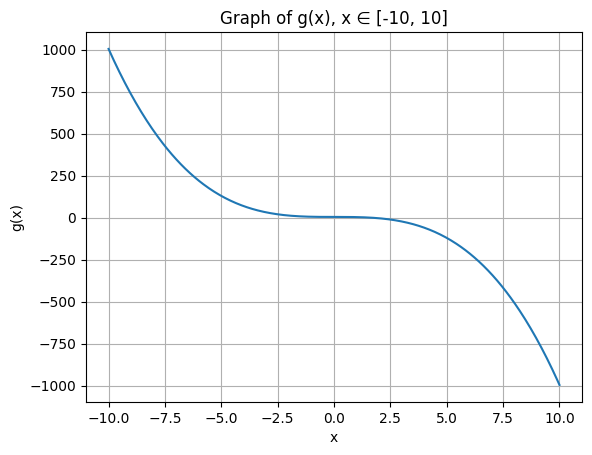

In [66]:
if __name__ == '__main__':
    calculator = Calculator()
    calculator.run()

# Load from and save to CSV, by Daniel

In [67]:

import csv
import ast
import operator
ops = {
    ast.Add: operator.add,
    ast.Sub: operator.sub,
    ast.Mult: operator.mul,
    ast.Div: operator.truediv,
    ast.USub: operator.neg
}

def safe_eval(expr):

    def _eval(node):
        if isinstance(node, ast.Constant):
            if isinstance(node.value, (int, float)):
                return node.value
            else:
                raise ValueError("Invalid constant")
        elif isinstance(node, ast.UnaryOp):  # -x
            if type(node.op) not in ops:
                raise ValueError("Unsupported operator")
            return ops[type(node.op)](_eval(node.operand))
        elif isinstance(node, ast.BinOp):    # x + y
            if type(node.op) not in ops:
                raise ValueError("Unsupported operator")
            return ops[type(node.op)](_eval(node.left), _eval(node.right))
        else:
            raise ValueError(f"Invalid expression: {expr}")

    node = ast.parse(expr, mode="eval").body
    return _eval(node)

# -------------------------------
# MAIN PROGRAM
# -------------------------------
f = "data.csv"

while True:
    print("\n=== Equation Storage System ===")
    print("1) Save a new equation")
    print("2) Load + solve an equation")
    print("3) Exit")

    choice = input("Choose an option: ")

    # -------------------------------
    # OPTION 1: SAVE EQUATION
    # -------------------------------
    if choice == "1":
        eq = input("Enter an equation to store: ")

        if not any(op in eq for op in ["+", "-", "*", "/"]):
            print("Please include at least one operator (+ - * /).")
            continue

        try:
            with open(f, newline="") as file:
                existing_lines = sum(1 for _ in file)
        except FileNotFoundError:
            existing_lines = 0

        next_id = existing_lines + 1

        with open(f, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([next_id, eq])

        print(f"Equation saved with ID #{next_id}")

    # -------------------------------
    # OPTION 2: LOAD + SOLVE EQUATION
    # -------------------------------
    elif choice == "2":
        try:
            eq_id = int(input("Enter equation ID to load: "))
        except ValueError:
            print("Invalid number.")
            continue

        found = False

        try:
            with open(f, newline="") as file:
                reader = csv.reader(file)
                for row in reader:
                    if int(row[0]) == eq_id:
                        equation = row[1]
                        print(f"\nEquation #{eq_id}: {equation}")
                        try:
                            result = safe_eval(equation)
                            print(f"Result: {result}")
                        except Exception as e:
                            print(f"Error evaluating equation: {e}")
                        found = True
                        break
        except FileNotFoundError:
            print("No saved equations yet!")
            continue

        if not found:
            print("No equation found with that ID.")

    # -------------------------------
    # OPTION 3: EXIT
    # -------------------------------
    elif choice == "3":
        print("Goodbye!")
        break

    else:
        print("Invalid option. Try again.")



=== Equation Storage System ===
1) Save a new equation
2) Load + solve an equation
3) Exit


KeyboardInterrupt: Interrupted by user